## Описание проекта

***Прогнозирование температуры звезды***

Задача от обсерватории «Небо на ладони»:

Придумать, как с помощью нейросети определять температуру на поверхности обнаруженных звёзд. Обычно для расчёта температуры учёные пользуются следующими методами:
* Закон смещения Вина;
* Закон Стефана-Больцмана;
* Спектральный анализ.

Каждый из них имеет плюсы и минусы. Обсерватория хочет внедрить технологии машинного обучения для предсказания температуры звёзд, надеясь, что этот метод будет наиболее точным и удобным.
В базе обсерватории есть характеристики уже изученных 240 звёзд.

## Загрузка данных

In [1]:
import pandas as pd
import numpy as np
from math import ceil
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from skorch.callbacks import EpochScoring, EarlyStopping
from skorch.dataset import ValidSplit 

from skorch import NeuralNetRegressor

from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

In [2]:
df = pd.read_csv('./datasets/6_class.csv')

## Предобработка и анализ данных

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              240 non-null    int64  
 1   Temperature (K)         240 non-null    int64  
 2   Luminosity(L/Lo)        240 non-null    float64
 3   Radius(R/Ro)            240 non-null    float64
 4   Absolute magnitude(Mv)  240 non-null    float64
 5   Star type               240 non-null    int64  
 6   Star color              240 non-null    object 
dtypes: float64(3), int64(3), object(1)
memory usage: 13.2+ KB


***Признаки***
* `Luminosity(L/Lo)` - относительная светимость L/Lo: светимость звезды относительно Солнца;
* `Radius(R/Ro)` - относительный радиус R/Ro: радиус звезды относительно радиуса Солнца;
* `Absolute magnitude(Mv)` - абсолютная звёздная величина Mv: физическая величина, характеризующая блеск звезды;
* `Star color` - цвет звезды, который определяют на основе спектрального анализа;
* `Star type` - тип звезды.

***Ключевой признак***

* `Temperature (K)` - абсолютная температура T(K): температура на поверхности звезды в Кельвинах.

In [4]:
df.head(10)

,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,0,3068,0.002400,0.1700,16.12,0,Red
1,1,3042,0.000500,0.1542,16.60,0,Red
2,2,2600,0.000300,0.1020,18.70,0,Red
3,3,2800,0.000200,0.1600,16.65,0,Red
4,4,1939,0.000138,0.1030,20.06,0,Red
5,5,2840,0.000650,0.1100,16.98,0,Red
6,6,2637,0.000730,0.1270,17.22,0,Red
7,7,2600,0.000400,0.0960,17.40,0,Red
8,8,2650,0.000690,0.1100,17.45,0,Red
9,9,2700,0.000180,0.1300,16.05,0,Red


* Удалим лишний столбец `Unnamed: 0` - он дублирует индексы таблицы;
* Оптимизируем размерность типов данных, для ускорения работы с датафреймом;
* Заменим имена столбцов на более удобный вариант.

In [5]:
df.drop(['Unnamed: 0'], inplace=True, axis=1)
df['Temperature (K)'] = pd.to_numeric(df['Temperature (K)'], downcast='integer')
df['Star type'] = pd.to_numeric(df['Star type'], downcast='integer')
df['Luminosity(L/Lo)'] = pd.to_numeric(df['Luminosity(L/Lo)'], downcast='float')
df['Radius(R/Ro)'] = pd.to_numeric(df['Radius(R/Ro)'], downcast='float')
df['Absolute magnitude(Mv)'] = pd.to_numeric(df['Absolute magnitude(Mv)'], downcast='float')
df.rename(columns={'Temperature (K)': 'temperature_k',
                   'Star type': 'star_type',
                   'Luminosity(L/Lo)': 'luminosity_l_lo',
                   'Radius(R/Ro)': 'radius_r_ro',
                   'Absolute magnitude(Mv)': 'absolute_magnitude_mv',
                   'Star color': 'star_color'}, inplace=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   temperature_k          240 non-null    int32  
 1   luminosity_l_lo        240 non-null    float32
 2   radius_r_ro            240 non-null    float32
 3   absolute_magnitude_mv  240 non-null    float32
 4   star_type              240 non-null    int8   
 5   star_color             240 non-null    object 
dtypes: float32(3), int32(1), int8(1), object(1)
memory usage: 6.0+ KB


Проверим данные на наличие пропусков

In [7]:
df.isna().mean()

temperature_k            0.0
luminosity_l_lo          0.0
radius_r_ro              0.0
absolute_magnitude_mv    0.0
star_type                0.0
star_color               0.0
dtype: float64

* Пропусков не обнаружено

Создадим списки с названиями столбцов: категориальных, числовых и ключевого признака

In [8]:
cat = ['star_type', 'star_color']
num = ['luminosity_l_lo', 'radius_r_ro', 'absolute_magnitude_mv']
target = ['temperature_k']

Посмотрим статистические данные для числовых признаков и ключевого признака

In [9]:
df[num + target].describe()

,luminosity_l_lo,radius_r_ro,absolute_magnitude_mv,temperature_k
count,240.000000,240.000000,240.000000,240.000000
mean,107188.359375,237.157776,4.382396,10497.462500
std,179432.250000,517.155762,10.532513,9552.425037
min,0.000080,0.008400,-11.920000,1939.000000
25%,0.000865,0.102750,-6.232500,3344.250000
50%,0.070500,0.762500,8.313000,5776.000000
75%,198050.000000,42.750000,13.697500,15055.500000
max,849420.000000,1948.500000,20.059999,40000.000000


* ***относительная светимость L/Lo*** - колеблется в очень широком диапазоне от $8*10^{-5}$ до $8*10^{5}$
* ***относительный радиус R/Ro*** - колеблется в очень широком диапазоне от 0,0084 до 1948

In [10]:
name_planet = ['Коричневый карлик', 'Красный карлик',
               'Белый карлик', 'Звёзды главной последовательности',
               'Сверхгиганты', 'Гипергиганты']

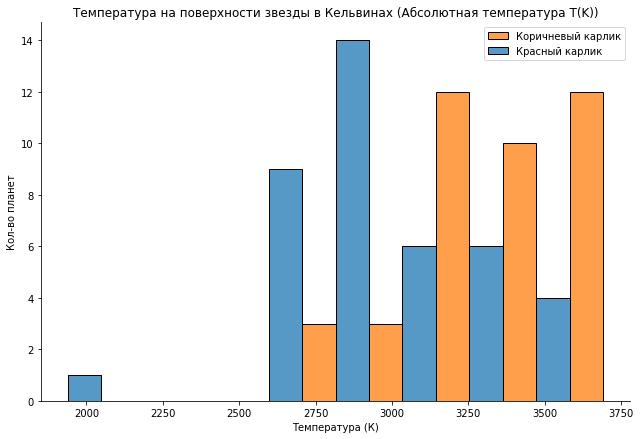

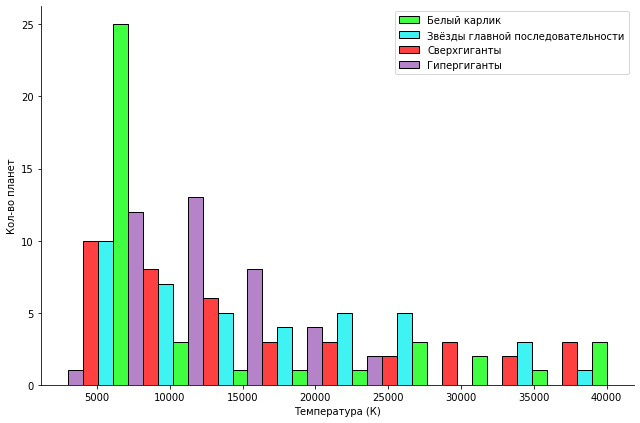

In [11]:
# Коричневый карлик и красный карлик
sns.displot(data=df[df.star_type <= 1], x='temperature_k', hue='star_type',
            multiple='dodge', legend=False, height=6, aspect=1.5)
plt.xlabel("Температура (К)")
plt.ylabel("Кол-во планет")
plt.title("Температура на поверхности звезды в Кельвинах (Абсолютная температура T(K))")
plt.legend(name_planet[0:2])

# Белый карлик, звёзды главной последовательности, сверхгиганты и гипергиганты
sns.displot(data=df[df.star_type > 1], x='temperature_k', hue='star_type',
            multiple='dodge', legend=False,
            palette=["#9b59b6", "#ff0000", "#00f0f0", "#00ff00"],
            height=6, aspect=1.5)
plt.xlabel("Температура (К)")
plt.ylabel("Кол-во планет")
plt.legend(name_planet[2:])
plt.show()

* Прослеживается зависимость температуры от типа звезды: у коричневых и красных карликов, температура колеблется от 2 тыс. до 4 тыс. к., а у остальных звёзд температура от 5 тыс. до 40 тыс. к.

Относительная светимость L/Lo — светимость звезды относительно Солнца


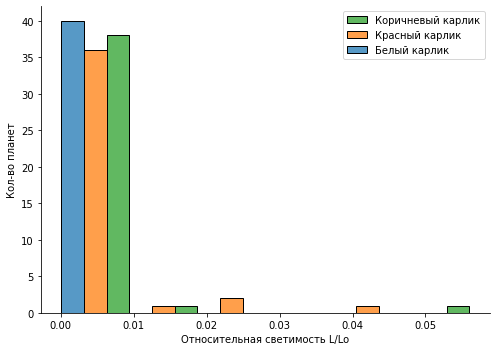

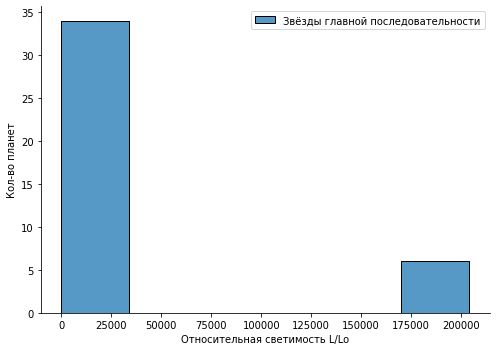

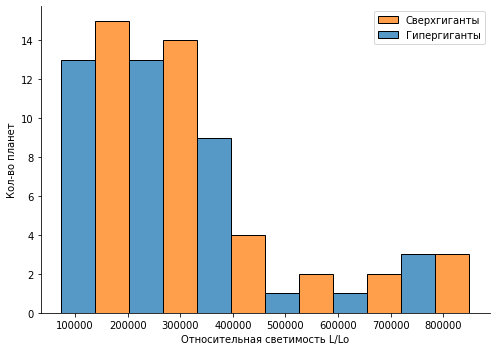

In [12]:
print('Относительная светимость L/Lo — светимость звезды относительно Солнца')
for i in [[0, 1, 2], [3], [4, 5]]:
    sns.displot(data=df[df.star_type.isin(i)], x='luminosity_l_lo',
                hue='star_type', multiple='dodge', legend=False,
                height=5, aspect=1.4, palette="tab10", bins=6)
    plt.xlabel("Относительная светимость L/Lo")
    plt.ylabel("Кол-во планет")
    plt.legend(name_planet[i[0]:i[-1] + 1])    

* Прослеживается зависимость относительной светимости от типа звезды: у карликов звёзд, относительная светимость очень низкая - меньше 0.1,а у сверхгигантов и гипергигантов относительная светимость от 100 тыс. до 800 тыс.

Относительный радиус R/Ro — радиус звезды относительно радиуса Солнца


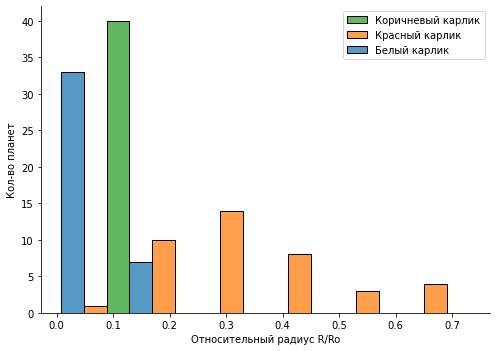

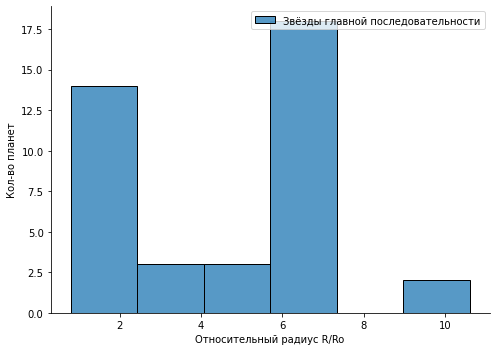

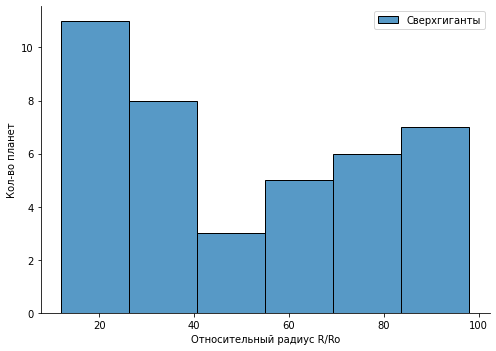

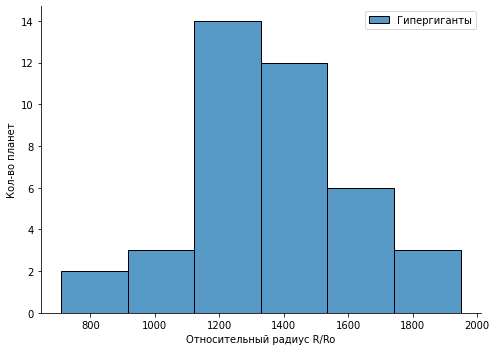

In [13]:
print('Относительный радиус R/Ro — радиус звезды относительно радиуса Солнца')
for i in [[0, 1, 2], [3], [4], [5]]:
    sns.displot(data=df[df.star_type.isin(i)], x='radius_r_ro',
                hue='star_type', multiple='dodge', legend=False,
                height=5, aspect=1.4, palette="tab10", bins=6)
    plt.xlabel("Относительный радиус R/Ro")
    plt.ylabel("Кол-во планет")
    plt.legend(name_planet[i[0]:i[-1] + 1])  

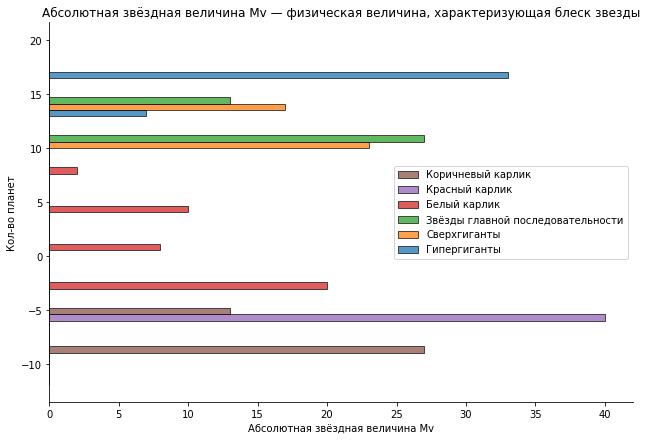

In [14]:
sns.displot(data=df, y='absolute_magnitude_mv',
            hue='star_type', multiple='dodge', legend=False,
            height=6, aspect=1.5, palette="tab10")
plt.xlabel("Абсолютная звёздная величина Mv")
plt.ylabel("Кол-во планет")
plt.title("Абсолютная звёздная величина Mv — физическая величина, характеризующая блеск звезды")
plt.legend(name_planet)  

In [15]:
df['star_type'].value_counts()

0    40
1    40
2    40
3    40
4    40
5    40
Name: star_type, dtype: int64

In [16]:
df.star_color.value_counts()

Red                   112
Blue                   55
Blue-white             26
Blue White             10
yellow-white            8
White                   7
white                   3
Blue white              3
Yellowish White         3
yellowish               2
Orange                  2
Whitish                 2
Orange-Red              1
Blue-White              1
White-Yellow            1
Blue                    1
Blue white              1
Pale yellow orange      1
Yellowish               1
Name: star_color, dtype: int64

Подправим наименование цветов звёзд, так как есть одинаковые цветы, но записанные по разному

In [17]:
df['star_color'] = df['star_color'].map(str.strip)
df.loc[df.star_color.isin(['Blue White', 'Blue white', 'Blue-White']), 'star_color'] = 'Blue-white'
df.loc[df.star_color.isin(['yellow-white', 'Yellowish White',
                           'White-Yellow', 'White-Yellow',
                           'yellowish', 'Yellowish']), 'star_color'] = 'Yellow-white'
df.loc[df.star_color.isin(['yellowish']), 'star_color'] = 'Yellowish'
df.loc[df.star_color.isin(['white', 'Whitish']), 'star_color'] = 'White'
df.loc[df.star_color.isin(['Orange', 'Orange-Red',
                           'Pale yellow orange']), 'star_color'] = 'Red'

In [18]:
df['star_color'].value_counts()

Red             116
Blue             56
Blue-white       41
Yellow-white     15
White            12
Name: star_color, dtype: int64

### Матрицы корреляций

Построим матрицу корреляций

In [19]:
df_corr = df.drop(['star_type', 'star_color'], axis=1)

In [20]:
df_corr.rename(columns={'temperature_k': 'Абсолютная температура T(K)',
                   'luminosity_l_lo': 'Относительная светимость L/Lo',
                   'radius_r_ro': 'Относительный радиус R/Ro',
                   'absolute_magnitude_mv': 'Абсолютная звёздная величина Mv'},
                   inplace=True)

<AxesSubplot:>

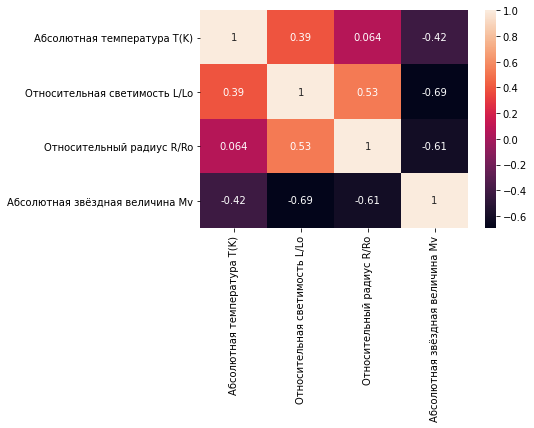

In [21]:
corr_matrix = df_corr.corr()
sns.heatmap(corr_matrix, annot = True)

Обнаружены следующие линейные зависимости:
* Абсолютная температура имеет прямую средюю зависимость (0,39) от относительной светимости и обратную среднюю зависимость (-0,42) от абсолютной звёздной велечины;
* Относительная светимость имеет прямую средюю зависимость (0,53) от относительного радиуса и обратную сильную зависимость (-0,69) от абсолютной звёздной велечины;
* Относительный радиус имеет обратную сильную зависимость (-0,61) от абсолютной звёздной велечины.

### Разбиение данных на выборки

In [22]:
df = df.sample(frac=1, random_state=12345)

df_features_str = df[['star_type', 'star_color']]
df_features_num = df.drop(['temperature_k', 'star_type', 'star_color'], axis=1)
df_target = df['temperature_k']

df_train_features_str, df_test_features_str,\
df_train_features_num, df_test_features_num,\
df_train_target, df_test_target\
= train_test_split(df_features_str, df_features_num, df_target,
                   test_size=0.3,shuffle=True, random_state=12345, stratify=df['star_type'])

print(f'Итоговые размеры выборок, обучающая:тестовая:\
 {df_train_target.count()}:{df_test_target.count()}')

Итоговые размеры выборок, обучающая:тестовая: 168:72


### Прямое кодирование

In [23]:
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
encoder.fit(df_train_features_str)
df_train_features_str = pd.DataFrame(encoder.transform(df_train_features_str)).astype('int8')
df_test_features_str = pd.DataFrame(encoder.transform(df_test_features_str)).astype('int8')

### Масштабирование числовых признаков признаков

In [24]:
scaler = StandardScaler()
scaler.fit(df_train_features_num) 
df_train_features_num = pd.DataFrame(scaler.transform(df_train_features_num))
df_test_features_num  = pd.DataFrame(scaler.transform(df_test_features_num))

### Объединение таблиц

In [25]:
df_train_features = pd.concat([df_train_features_num, df_train_features_str], axis=1)
df_test_features = pd.concat([df_test_features_num, df_test_features_str], axis=1)

In [26]:
X_train = torch.Tensor(df_train_features.values)
X_test = torch.Tensor(df_test_features.values)
y_train = torch.Tensor(df_train_target.values)
y_test = torch.Tensor(df_test_target.values)

* Данные подготовлены, можно переходить к обучению нейронной сети

## Построение базовой нейронной сети

In [27]:
np.random.seed(12345)
torch.manual_seed(12345)
torch.use_deterministic_algorithms(True)

Создадим класс для задания архитектуры нейронной сети

In [28]:
class baseline(nn.Module):
    def __init__(self, n_in, n_2, n_3, n_4, n_out, dp1, dp2,
                 dp3, act1, act2, act3):
        super(baseline, self).__init__()
        
        self.fc1 = nn.Linear(n_in, n_2)
        self.act1 = act1
        self.dp1 = nn.Dropout(dp1)
        
        self.fc2 = nn.Linear(n_2, n_3)
        self.act2 = act2
        self.dp2 = nn.Dropout(dp2)
        
        self.fc3 = nn.Linear(n_3, n_4)
        self.act3 = act3
        self.dp3 = nn.Dropout(dp3)
        
        self.fc4 = nn.Linear(n_4, n_out)

    def forward(self, x):
        
        x = self.dp1(self.act1(self.fc1(x)))
        x = self.dp2(self.act2(self.fc2(x)))
        x = self.dp3(self.act3(self.fc3(x)))
        x = self.fc4(x)
        
        return x
    
    def init_weights(m):
        if isinstance(m, nn.Linear):
            torch.nn.init.kaiming_normal_(m.weight)
            m.bias.data.fill_(0.01)

In [29]:
class CustomEarlyStopping():
    """
    Ранняя остановка, чтобы остановить тренировку, когда потеря не улучшается после определенной эпохи.
    """
    def __init__(self, patience=5, min_delta=0):
        """
        :param patience: сколько эпох ждать, прежде чем остановиться, когда потеря не улучшается
        :param min_delta: минимальная разница между loss/метриками, если улучшений нет, то остановим обучение
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.counter_in_row = 0
            if self.best_loss > val_loss:
                self.best_loss = val_loss
                # reset counter if validation loss improves
                self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience: 
                print('INFO: Early stopping')
                self.early_stop = True

Укажим параметры нейронной сети: кол-во нейронов, эпох и размер батча

In [30]:
n_in, n_2, n_3, n_4, n_out = 14, 20, 70, 40, 1
act1, act2, act3 = nn.ReLU(), nn.ReLU(), nn.ReLU()
dp1 , dp2, dp3 = 0.1, 0.1, 0.1
num_epochs = 10000
batch_size = 60
num_batches = ceil(len(X_train)/batch_size)

In [31]:
net = baseline(n_in, n_2, n_3, n_4, n_out, dp1, dp2, dp3, act1, act2, act3)
loss = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

Обучим нашу нейронную сеть

In [32]:
early_stopping = CustomEarlyStopping(patience=5, min_delta=-20)
for epoch in range(num_epochs):
    net.train()
    order = np.random.permutation(len(X_train))
    for batch_idx in range(num_batches):
        start_index = batch_idx * batch_size
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        X_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]
        preds = net.forward(X_batch).flatten()
        loss_value = torch.sqrt(loss(y_batch, preds))
        loss_value.backward()
                
        optimizer.step()

    if epoch % 50 == 0 or epoch == num_epochs - 1:
        net.eval()
        test_preds = net.forward(X_test).flatten()
        rmse = torch.sqrt(loss(test_preds, y_test))
        print(epoch, 'RMSE:', rmse)
        early_stopping(rmse)
        
        if early_stopping.early_stop:
            print('Early Stoppning!!!')
            break

0 RMSE: tensor(13805.1416, grad_fn=<SqrtBackward0>)
50 RMSE: tensor(13511.7148, grad_fn=<SqrtBackward0>)
100 RMSE: tensor(7775.3276, grad_fn=<SqrtBackward0>)
150 RMSE: tensor(6219.1108, grad_fn=<SqrtBackward0>)
200 RMSE: tensor(5857.1553, grad_fn=<SqrtBackward0>)
250 RMSE: tensor(5530.8179, grad_fn=<SqrtBackward0>)
300 RMSE: tensor(5304.1807, grad_fn=<SqrtBackward0>)
350 RMSE: tensor(5145.4121, grad_fn=<SqrtBackward0>)
400 RMSE: tensor(5034.6924, grad_fn=<SqrtBackward0>)
450 RMSE: tensor(4923.8271, grad_fn=<SqrtBackward0>)
500 RMSE: tensor(4829.4668, grad_fn=<SqrtBackward0>)
550 RMSE: tensor(4757.9526, grad_fn=<SqrtBackward0>)
600 RMSE: tensor(4686.5161, grad_fn=<SqrtBackward0>)
650 RMSE: tensor(4622.8799, grad_fn=<SqrtBackward0>)
700 RMSE: tensor(4600.5962, grad_fn=<SqrtBackward0>)
750 RMSE: tensor(4564.4272, grad_fn=<SqrtBackward0>)
800 RMSE: tensor(4542.5298, grad_fn=<SqrtBackward0>)
850 RMSE: tensor(4516.9771, grad_fn=<SqrtBackward0>)
900 RMSE: tensor(4503.7383, grad_fn=<SqrtBackwa

* Значение метрики RMSE равно 4481, полученной значение, ниже заданного максимума - 4500, получили хороший результат, но попробуем его ещё улучшить

Постром график: прогноз и факт

In [33]:
fact_forecast = pd.DataFrame(data = {'Факт':y_test.numpy(),
                                     'Прогноз':test_preds.data.numpy().reshape(1, -1)[0]},
                                      columns=['Факт', 'Прогноз'])

In [34]:
def final_graph(df_graph):
    
    fig, ax = plt.subplots(figsize=(14, 7))

    ax.bar(df_graph.index, df_graph['Факт'], color='#aae6f2', width=0.6)
    ax.bar(df_graph.index, df_graph['Прогноз'], color='#ffc001', width=0.3)

    plt.ylabel("Температура звезды")
    plt.xlabel("Номер звезды в таблице данных")
    plt.legend(['Факт', 'Прогноз'], loc='upper center')
    plt.show()

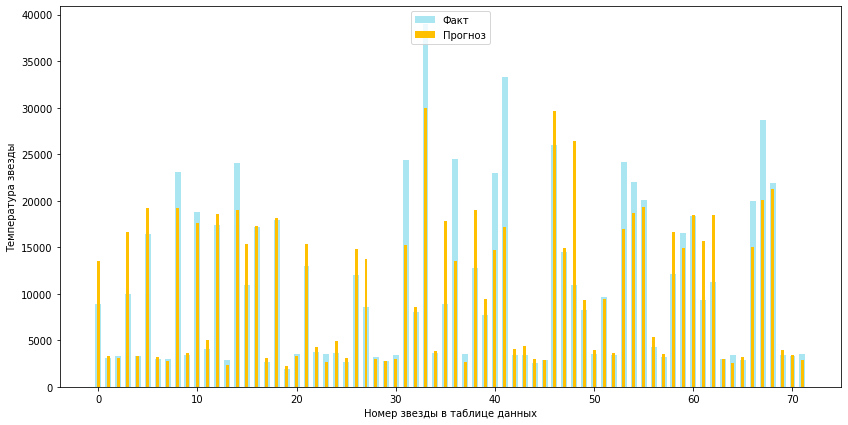

In [35]:
final_graph(fact_forecast)

## Улучшение нейронной сети

Создадим функцию вычисляющию метрику RMSE

In [36]:
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

In [37]:
rmse_scorer = make_scorer(rmse)

In [38]:
net = baseline(n_in, n_2, n_3, n_4, n_out, dp1, dp2, dp3,
              act1, act2, act3)

Обернём модель с помощью skorch

In [39]:
skorch_regressor = NeuralNetRegressor(module=net, 
                                  device='cpu',  
                                  verbose=0,
                                  optimizer=torch.optim.Adam, 
                                  max_epochs=5000,
                                  train_split=ValidSplit(cv=5),
                                  criterion =nn.MSELoss,
                                  callbacks=[
            ('val_rmse', EpochScoring(scoring=rmse_scorer, lower_is_better=True, name='RMSE')),
            ('estoper', EarlyStopping(lower_is_better=True, monitor='RMSE', patience=60)),
        ]) 

Зададим параметры для поиска наилучших

In [40]:
 params = {
    'module__n_in': [14],
    'module__n_2': range(10, 71, 2),
    'module__n_3': range(10, 71, 2),
    'module__n_4': range(10, 71, 2),
    'module__n_out': [1],
    'module__dp1': np.arange(0.0, 0.31, 0.1),
    'module__dp2': np.arange(0.0, 0.31, 0.1),
    'module__dp3': np.arange(0.0, 0.31, 0.1),
    'module__act1': [nn.ReLU(), nn.ELU()],
    'module__act2': [nn.ReLU(), nn.ELU()],
    'module__act3': [nn.ReLU(), nn.ELU()],
    'lr': np.arange(0.002, 0.0101, 0.001),
    'batch_size' : range(20, 71, 5)
}

Подъберем наилучшие параметры с помощью RandomizedSearchCV

In [41]:
%%time
grid = RandomizedSearchCV(skorch_regressor, params, cv=3, n_iter=500,
                          scoring="neg_root_mean_squared_error",
                          verbose=3, random_state=12345, n_jobs=-1) 
grid.fit(X_train, y_train.reshape(-1,1)) 

Fitting 3 folds for each of 500 candidates, totalling 1500 fits
CPU times: total: 50 s
Wall time: 5min 16s


RandomizedSearchCV(cv=3,
                   estimator=<class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=baseline(
    (fc1): Linear(in_features=14, out_features=20, bias=True)
    (act1): ReLU()
    (dp1): Dropout(p=0.1, inplace=False)
    (fc2): Linear(in_features=20, out_features=70, bias=True)
    (act2): ReLU()
    (dp2): Dropout(p=0.1, inplace=False)
    (fc3): Linear(in_features=70, out_featur...
                                                         ELU(alpha=1.0)],
                                        'module__act3': [ReLU(),
                                                         ELU(alpha=1.0)],
                                        'module__dp1': array([0. , 0.1, 0.2, 0.3]),
                                        'module__dp2': array([0. , 0.1, 0.2, 0.3]),
                                        'module__dp3': array([0. , 0.1, 0.2, 0.3]),
                                        'module__n_2': range(10, 71, 2),
                                   

Выведем на экран лучшие параметры модели

In [42]:
grid.best_params_

{'module__n_out': 1,
 'module__n_in': 14,
 'module__n_4': 70,
 'module__n_3': 32,
 'module__n_2': 10,
 'module__dp3': 0.30000000000000004,
 'module__dp2': 0.0,
 'module__dp1': 0.0,
 'module__act3': ReLU(),
 'module__act2': ReLU(),
 'module__act1': ELU(alpha=1.0),
 'lr': 0.003,
 'batch_size': 50}

Проверим метрику RMSE на тестовых данных

In [43]:
best_preds = grid.predict(X_test)
rmse(y_test.reshape(-1,1), best_preds)

4199.7847

* Значение метрики RMSE улучшилось до 4200.

Постром график: прогноз и факт

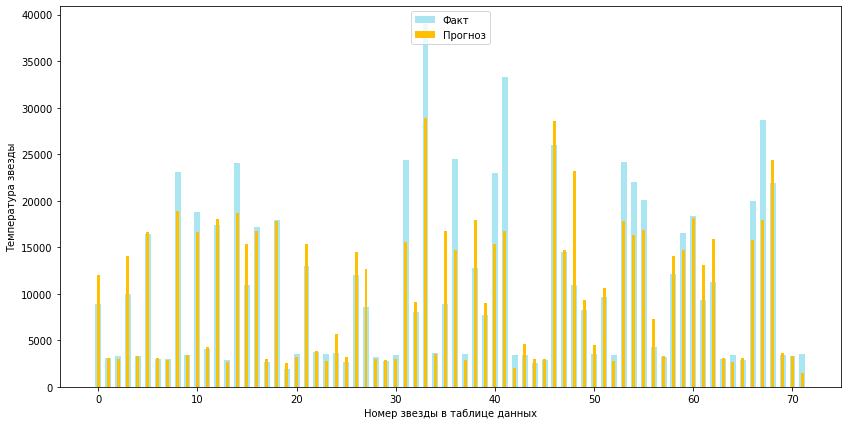

In [44]:
fact_forecast = pd.DataFrame(data = {'Факт':y_test.numpy(),
                                     'Прогноз':best_preds.reshape(1, -1)[0]},
                                     columns=['Факт', 'Прогноз'])
final_graph(fact_forecast)

## Выводы

Нейронная сеть  | Кол-во скрытых слоёв | Кол-во нейронов по слоям | Функции активации | Dropout | Learning rate| Batch size | RMSE
:------- | :--------:| :--------:| :--------:| :--------:| :--------:| :--------:| :--------:
Базовая  |2 | 14, 20, 70, 40, 1 | ReLU(), ReLU(), ReLU() | 0.1, 0.1, 0.1 | 0.001 | 60 | 4481
Улучшенная   | 2 | 14, 10, 32, 70, 1 | ELU(), ReLU(), ReLU()| 0, 0, 0.3 | 0.003 | 50 | 4200

* Базовая нейронная сеть показала хорошие показатели RMSE - 4481;

* Улучшенная нейронная сеть, превзошла результаты базовой модели, метрика RMSE - 4200.